In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

In [467]:
# df = pd.read_csv('datasets/jolts/jt.data.2.JobOpenings', sep='\t')
# df = pd.read_csv('datasets/jolts/jt.data.5.Quits', sep='\t')
df = pd.read_csv('datasets/jolts/jt.data.6.LayoffsDischarges', sep='\t')
# df = pd.read_csv('datasets/jolts/jt.data.8.UnemployedPerJobOpeningRatio', sep='\t')
df.columns = ['series_id', 'year', 'period', 'value', 'footnote_codes']
df['series_id'] = df['series_id'].str.strip()

In [468]:
df['naics_code'] = df['series_id'].str.slice(3, 9)
df['state_code'] = df['series_id'].str.slice(9, 11)
df['area_code'] = df['series_id'].str.slice(11, 13)

In [469]:
df[df['year'].eq(2022) & df['series_id'].str.endswith('R') & df['period'].eq('M13')]

,series_id,year,period,value,footnote_codes,naics_code,state_code,area_code
50071,JTU000000000000000LDR,2022,M13,1.0,NaN,000000,00,00
50673,JTU000000010000000LDR,2022,M13,1.0,NaN,000000,01,00
51275,JTU000000020000000LDR,2022,M13,1.8,NaN,000000,02,00
51877,JTU000000040000000LDR,2022,M13,0.9,NaN,000000,04,00
52479,JTU000000050000000LDR,2022,M13,1.0,NaN,000000,05,00
...,...,...,...,...,...,...,...,...
100363,JTU900000000000000LDR,2022,M13,0.4,NaN,900000,00,00
100965,JTU910000000000000LDR,2022,M13,0.3,NaN,910000,00,00
101567,JTU920000000000000LDR,2022,M13,0.4,NaN,920000,00,00
102169,JTU923000000000000LDR,2022,M13,0.3,NaN,923000,00,00


In [470]:
jts = df[df['series_id'].str.endswith('R') & df['series_id'].str.slice(2, 11).eq('S00000000')]

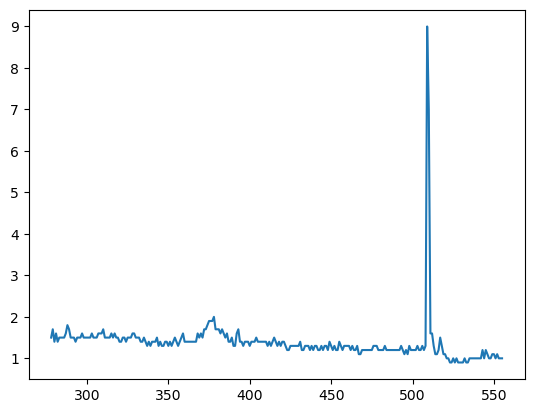

In [471]:
jts.sort_values(['year', 'period'])['value'].plot.line();

In [472]:
naics_mapping = {
    11: 'Agriculture, forestry, fishing and hunting',
    21: 'Mining',
    22: 'Utilities',
    23: 'Construction',
    31: 'Manufacturing',
    32: 'Manufacturing',
    33: 'Manufacturing',
    42: 'Wholesale trade',
    44: 'Retail trade',
    45: 'Retail trade',
    48: 'Transportation and warehousing',
    49: 'Transporation and warehousing',
    51: 'Information',
    52: 'Finance and insurance',
    53: 'Real estate and rental and leasing',
    54: 'Professional, Scientific, and Technical Services',
    55: 'Management of Companies and Enterprises',
    56: 'Administrative and support and waste management and remediation services',
    61: 'Education services',
    62: 'Health care and social assistance',
    71: 'Arts, entertainment, and recreation',
    72: 'Accommodation and food services',
    81: 'Other services, except public administration',
    92: 'Public administration',
}

In [473]:
occupations = pl.read_csv('datasets/db_26_3_text/Occupation Level Metadata.txt', separator='\t')
jobs_aii = pd.read_csv('datasets/2022/jobs_aii.csv')

In [474]:
from scipy.stats import beta

def compute_industry_scores(occupations, jobs_aii, year=None):
    data = (
        occupations
        .filter(pl.col('Item') == 'NAICS Sector')
        .filter(pl.col('Percent') != 'n/a')
        .join(pl.from_dataframe(jobs_aii), on='O*NET-SOC Code')
        .filter(pl.col('Percent').cast(float) > 50)
        .with_columns(
            (pl.col('Percent').cast(float) * pl.col('aii')).alias('score')
        )
        .group_by('Response')
        .agg(
            pl.col('score').sum(),
            pl.col('Percent').cast(float).sum()
        )
        .filter(pl.col('Response') != 'Unclassified')
        .sort('score')
        .to_pandas()
    )

    # Using conservative views and a weakly informative prior
    data['aii'] = beta(
        1 + data['score'],
        9 + data['Percent'] - data['score']
    ).ppf(.25)
    # data['aii'] = data['score'] / data['Percent']
    data['aii_std'] = beta(
        1 + data['score'],
        9 + data['Percent'] - data['score']
    ).std()

    if year:
        data['year'] = year

    return data

In [475]:
sector_aii = compute_industry_scores(occupations, jobs_aii)

In [476]:
sector_name = {
    'Accommodation and food services': 'Accommodation and food services',
    'Administrative and support and waste management and remediation services': 'Waste management',
    'Agriculture, forestry, fishing and hunting': 'Agriculture',
    'Arts, entertainment, and recreation': 'Arts and entertainment',
    'Construction': 'Construction',
    'Education services': 'Education',
    'Finance and insurance': 'Finance and insurance',
    'Health care and social assistance': 'Healthcare',
    'Information': 'Information technology',
    'Manufacturing': 'Manufacturing',
    'Mining': 'Mining',
    'Other services, except public administration': 'Other services',
    'Professional, Scientific and Technical Services': 'Scientific and technical services',
    'Public administration': 'Public administration',
    'Real estate and rental and leasing': 'Real estate',
    'Retail trade': 'Retail trade',
    'Transportation and warehousing': 'Transportation',
    'Utilities': 'Utilities',
    'Wholesale trade': 'Wholesale trade',
}

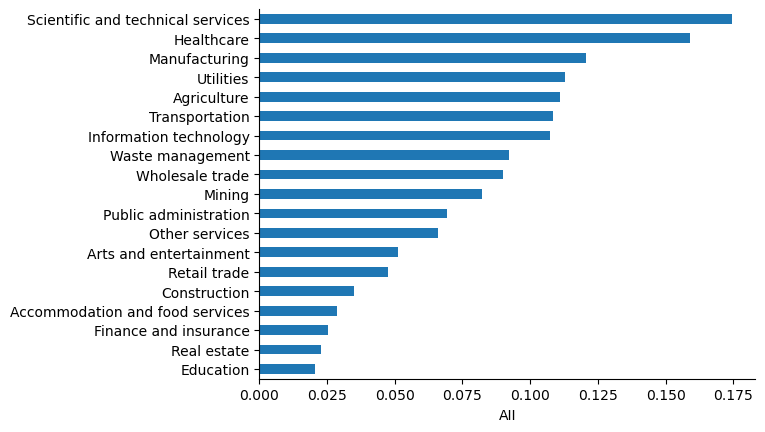

In [477]:
industry_scores = compute_industry_scores(occupations, jobs_aii)
industry_scores.set_index('Response').rename(sector_name).aii.sort_values().plot.barh()
plt.xlabel('AII')
plt.ylabel('')
sns.despine()

In [478]:
naics_mapping_jt = {
    '110099': 'Mining',
    '230000': 'Construction',
    '320000': 'Manufacturing',
    '340000': 'Manufacturing',
    '420000': 'Wholesale trade',
    '440000': 'Retail trade',
    '480099': 'Transportation and warehousing',
    '510000': 'Information',
    '510099': 'Financial activities',
    '520000': 'Finance and insurance',
    '530000': 'Real estate and rental and leasing',
    '540099': 'Professional, Scientific, and Technical Services',
    '610000': 'Education services',
    '620000': 'Health care and social assistance',
    '710000': 'Arts, entertainment, and recreation',
    '720000': 'Accommodation and food services',
    '810000': 'Other services, except public administration',
    '920000': 'Public administration',
}

In [486]:
year_mask = df['year'].eq(2022)
rate_mask = df['series_id'].str.endswith('R')
month_mask = df['period'].eq('M13')
seasonal_mask = df['series_id'].str[2] == 'U'
agg_mask = (df['naics_code'].str.endswith('0000') | df['naics_code'].str.endswith('0099')) & ~df['naics_code'].eq('000000') & ~df['naics_code'].eq('100000')
vacancy_rates = df[
    year_mask
    & rate_mask
    & month_mask
    & seasonal_mask
    & agg_mask
].reset_index(drop=True).copy()

vacancy_rates['sector_code'] = vacancy_rates['naics_code'].str.slice(0, 2).astype(int)
vacancy_rates['sector_name'] = vacancy_rates['naics_code'].map(naics_mapping_jt)

vacancy_rates = vacancy_rates.dropna(subset='sector_name')

In [487]:
vacancy_rates

,series_id,year,period,value,footnote_codes,naics_code,state_code,area_code,sector_code,sector_name
0,JTU110099000000000LDR,2022,M13,0.8,NaN,110099,00,00,11,Mining
1,JTU230000000000000LDR,2022,M13,1.9,NaN,230000,00,00,23,Construction
3,JTU320000000000000LDR,2022,M13,0.7,NaN,320000,00,00,32,Manufacturing
4,JTU340000000000000LDR,2022,M13,1.0,NaN,340000,00,00,34,Manufacturing
6,JTU420000000000000LDR,2022,M13,0.8,NaN,420000,00,00,42,Wholesale trade
7,JTU440000000000000LDR,2022,M13,0.9,NaN,440000,00,00,44,Retail trade
8,JTU480099000000000LDR,2022,M13,1.2,NaN,480099,00,00,48,Transportation and warehousing
9,JTU510000000000000LDR,2022,M13,1.2,NaN,510000,00,00,51,Information
10,JTU510099000000000LDR,2022,M13,0.5,NaN,510099,00,00,51,Financial activities
11,JTU520000000000000LDR,2022,M13,0.5,NaN,520000,00,00,52,Finance and insurance


In [488]:
jolts = pd.merge(
    vacancy_rates,
    industry_scores,
    how='left',
    left_on='sector_name',
    right_on='Response'
).dropna(subset='aii')

In [489]:
jolts

,series_id,year,period,value,footnote_codes,naics_code,state_code,area_code,sector_code,sector_name,Response,score,Percent,aii,aii_std
0,JTU110099000000000LDR,2022,M13,0.8,NaN,110099,00,00,11,Mining,Mining,59.493442,664.3,0.082084,0.010997
1,JTU230000000000000LDR,2022,M13,1.9,NaN,230000,00,00,23,Construction,Construction,116.758185,3149.4,0.034949,0.003370
2,JTU320000000000000LDR,2022,M13,0.7,NaN,320000,00,00,32,Manufacturing,Manufacturing,1284.104978,10457.2,0.120598,0.003208
3,JTU340000000000000LDR,2022,M13,1.0,NaN,340000,00,00,34,Manufacturing,Manufacturing,1284.104978,10457.2,0.120598,0.003208
4,JTU420000000000000LDR,2022,M13,0.8,NaN,420000,00,00,42,Wholesale trade,Wholesale trade,31.727847,311.9,0.089901,0.016818
5,JTU440000000000000LDR,2022,M13,0.9,NaN,440000,00,00,44,Retail trade,Retail trade,77.901798,1524.5,0.047517,0.005636
6,JTU480099000000000LDR,2022,M13,1.2,NaN,480099,00,00,48,Transportation and warehousing,Transportation and warehousing,281.595796,2494.5,0.108516,0.006321
7,JTU510000000000000LDR,2022,M13,1.2,NaN,510000,00,00,51,Information,Information,140.546530,1235.6,0.107464,0.008989
9,JTU520000000000000LDR,2022,M13,0.5,NaN,520000,00,00,52,Finance and insurance,Finance and insurance,22.572879,787.1,0.025340,0.005997
10,JTU530000000000000LDR,2022,M13,0.8,NaN,530000,00,00,53,Real estate and rental and leasing,Real estate and rental and leasing,5.263158,187.7,0.022647,0.012425


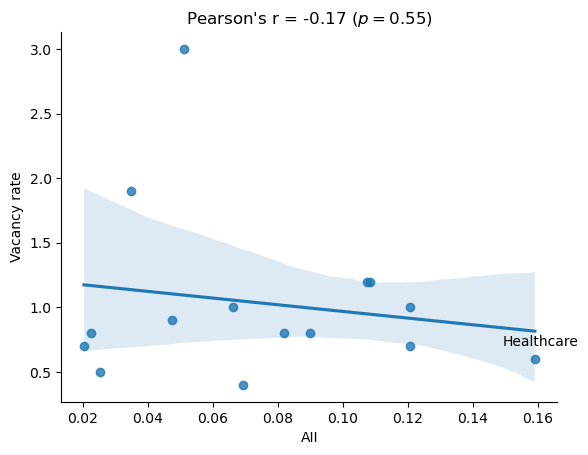

In [491]:
from scipy.stats import pearsonr

jd = jolts[~jolts['sector_name'].isin([
    # "Construction",
    # "Arts, entertainment, and recreation",
    "Accommodation and food services"
])]
# jd = jolts
rho, pval = pearsonr(jd['aii'], jd['value'])
sns.regplot(
    x='aii',
    y='value',
    data=jd
)
plt.title(f"Pearson's r = {rho:.2f} ($p = {pval:.2f}$)")
for sector in [
    'Health care and social assistance',
    # 'Accommodation and food services',
    # 'Information',
    # 'Arts, entertainment, recreation',
]:
    try:
        sector_data = jd[jd['sector_name'].eq(sector)].iloc[0]

        if sector.startswith('Health'):
            sector = 'Healthcare'
        elif sector.startswith('Accomm'):
            sector = 'Accommodation'
        elif sector.startswith('Arts'):
            sector = 'Arts & entertainment'

        plt.annotate(sector, (sector_data['aii'] - 0.01, sector_data['value'] + 0.1))
    except:
        pass
plt.xlabel('AII')
plt.ylabel('Vacancy rate')
sns.despine()
plt.savefig('figures/2022/layoff-sector.pdf', bbox_inches='tight')

# State

In [407]:
state = pd.read_csv('datasets/State-Grid view.csv')
state['vacancy_rate'] = state['Job Openings (thousands)'] / state['Employment (thousands)']
state['year'] = state['Period'].str[-4:].astype(int)
state = state[state['year'].eq(2022)]

In [450]:
state_stats = state.groupby('State').agg({
    'vacancy_rate': 'mean',
    'Unemployment Rate (%)': 'mean',
}).reset_index()
state_stats['vacancy_rate'] = state_stats['vacancy_rate'] * 100

In [451]:
state_aii = pd.read_csv('datasets/2022/aii_state.csv')

In [452]:
state_joined = pd.merge(
    state_stats,
    state_aii,
    how='inner',
    left_on='State',
    right_on='state_name'
)

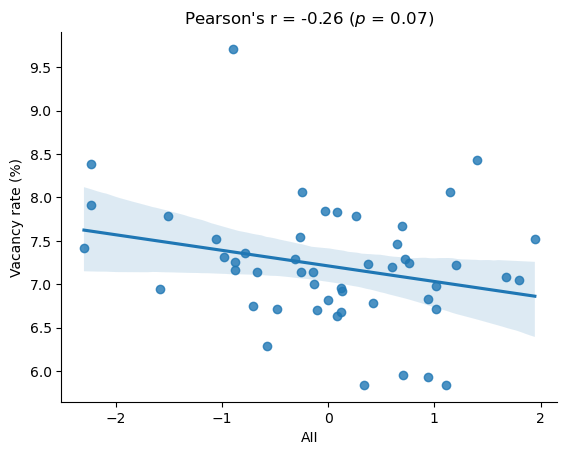

In [460]:
# var = 'Unemployment Rate (%)'
var = 'vacancy_rate'
state_data = (
    state_joined
    # [state_joined['state_name'].ne('Alaska')]
)
rho, pval = pearsonr(state_data[var], state_data['aii_scaled'])

sns.regplot(
    x='aii_scaled',
    y=var,
    data=state_data,
)
plt.title(f"Pearson's r = {rho:.2f} ($p$ = {pval:.2f})")
plt.xlabel('AII')
plt.ylabel('Vacancy rate (%)')
sns.despine()